# New Zealand Losgitics Sprawl 
## Mapping toolkit

### Step 1: Import libraries

In [191]:
# import necessary packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

import geoplot as gplt
import geopandas as gpd #used
import geoplot.crs as gcrs

#from shapely import wkt

import seaborn as sns
#import pysal
#import mapclassify as mc
#import imageio
#import pathlib
import math

import pandas as pd #used
import numpy as np #used


#from sklearn.neighbors import KernelDensity

#from sklearn.datasets import fetch_species_distributions


### Step 2: Define functions

#### Reading and subsetting Group A file

In [10]:
def readFileA(input_filename):
    #Read in the complete set
    groupA=pd.read_csv(input_filename)
    groupA=groupA.drop("Unnamed: 0",axis=1)
    #Strip all leading whitespace in Area column
    groupA['Area'] = groupA['Area'].apply(lambda x: x.strip())
    return(groupA)

def subsetFileA(df,arVal="",areaORparentArea="none",year=2020,TotInd_GeogUnits=False,TotInd_EmpCo=False,F_GeogUnits=False,F_EmpCo=False,G_GeogUnits=False,G_EmpCo=False,I461_GeogUnits=False,I461_EmpCo=False,I471_GeogUnits=False,I471_EmpCo=False,I481_GeogUnits=False,I481_EmpCo=False,I51_GeogUnits=False,I51_EmpCo=False,I53_GeogUnits=False,I53_EmpCo=False):
    #subset according to area / parent area
    if areaORparentArea == "area":
        df=df.loc[df['Area']==arVal,]
    elif areaORparentArea == "parentArea":
        df=df.loc[df['ParentArea']==arVal,]
    #subset according to year
    df=df.loc[df['Year']==year,]
    #retain only the required variable columns
    arr = np.array([True,TotInd_GeogUnits,TotInd_EmpCo,F_GeogUnits,F_EmpCo,G_GeogUnits,G_EmpCo,I461_GeogUnits,I461_EmpCo,I471_GeogUnits,I471_EmpCo,I481_GeogUnits,I481_EmpCo,I51_GeogUnits,I51_EmpCo,I53_GeogUnits,I53_EmpCo, True,True])
    df = df.loc[:, arr]
    return(df)

#### Legacy functions to convert coordinates
Legacy functions are functions that were used in the past to convert coordinates and csv files. These functions take VERY LONG to execute. It is recommended to rather just read in the converted csv's. The function are included here for completeness.

In [3]:
def create_e_n_TupleFileMultiPoly(input_filename,output_filename):
#Read in the original csv and parse out a file that only contains easting and northing coords
#This is for files with multipolygons
    f=open(input_filename)
    lines=f.readlines()
    f.close()
    rows_list = []
    for k in range(len(lines)):
        if lines[k].startswith('"MULTIPOLYGON ((('):
            cut=lines[k][(len('"MULTIPOLYGON (((')):lines[k].find(')))')] #cuts out the multipolygon
            cut=cut.replace(')',"")
            cut=cut.replace('(',"")
            tups=cut.split(',')
            for i in range(len(tups)):
                seps=tups[i].split(' ')
                dict1 = {}
                dict1.update({"easting":seps[0],"northing":seps[1]}) 
                rows_list.append(dict1)

    df = pd.DataFrame(rows_list) 
    df.to_csv(output_filename)


def create_e_n_TupleFilePoint(input_filename,output_filename):
#Read in the original csv and parse out a file that only contains easting and northing coords
#This is for files with points
    centroids=pd.read_csv("./statsnzstatistical-area-2-2020-centroid-true-CSV/statistical-area-2-2020-centroid-true.csv")
    #THIS CODE IS SO MUCH SHORTER BUT FOR SOME REASON IT UPSETS THE PLOTTING - No idea why
    #for k in range(len(centroids)):
    #    E_N=centroids.iloc[k,0][(len('POINT (')):centroids.iloc[k,0].find(')')] 
    #    lon_lat=str(centroids.iloc[k,7])+" "+str(centroids.iloc[k,6])  
    #    centroids.iloc[k,0]=centroids.iloc[k,0].replace(E_N,lon_lat)
    wkts=centroids['WKT']
    rowsList=[]
    for k in range(len(wkts)):
        cut=wkts[k][(len('POINT (')):wkts[k].find(')')] 
        seps=cut.split(' ')
        dict1 = {}
        dict1.update({"easting":seps[0],"northing":seps[1]}) 
        rowsList.append(dict1)
    df_centroidMercator = pd.DataFrame(rowsList) 
    df_centroidMercator.to_csv(output_filename)


def nztm_to_lat_long(input_filename, output_filename):
# read in a file that includes a list of easting and northing values 
# convert to lon and lat
#write out a file that has site-id, easting, northing, lon, lat
    infile = open(input_filename)
    lines = infile.readlines()
    infile.close()
        
    outfile = open(output_filename, 'w')
    outfile.write("site_id, easting, northing, longitude, latitude\n")
        
    for line in lines[1:]: #skip header row
        site_id, nztm_e, nztm_n = line.split(',')
        
            
        #Common variables for NZTM2000
        a = 6378137;
        f = 1 / 298.257222101;
        phizero = 0;
        lambdazero = 173;
        Nzero = 10000000;
        Ezero = 1600000;
        kzero = 0.9996;   
        
            
        #input Northing(Y); Easting(X) variables
        E  = float(nztm_e);#neither int(float(nztm_e)) or this produces the right decimals
        N  = float(nztm_n);
            
        #Calculation: From NZTM to lat/Long
        b = a * (1 - f);
        esq = 2 * f - f ** 2;
        Z0 = 1 - esq / 4 - 3 * (esq ** 2) / 64 - 5 * (esq ** 3) / 256;
        A2 = 0.375 * (esq + esq ** 2 / 4 + 15 * (esq ** 3) / 128);
        A4 = 15 * ((esq ** 2) + 3 * (esq ** 3) / 4) / 256;
        A6 = 35 * (esq ** 3) / 3072;
            
        Nprime = N - Nzero;
        mprime = Nprime / kzero;
        smn = (a - b) / (a + b);
        G = a * (1 - smn) * (1 - (smn ** 2)) * (1 + 9 * (smn ** 2) / 4 + 225 * (smn ** 4) / 64) * math.pi/ 180.0;
        sigma = mprime * math.pi / (180 * G);
        phiprime = sigma + (3 * smn / 2 - 27 * (smn ** 3) / 32) * math.sin(2 * sigma) + (21 * (smn ** 2) / 16 - 55 * (smn ** 4) / 32) * math.sin(4 * sigma) + (151 * (smn ** 3) / 96) * math.sin(6 * sigma) + (1097 * (smn ** 4) / 512) *math.sin(8 * sigma);
        rhoprime = a * (1 - esq) / ((1 - esq * ((math.sin(phiprime)) ** 2)) ** 1.5);
        upsilonprime = a / math.sqrt(1 - esq * ((math.sin(phiprime)) ** 2));
            
        psiprime = upsilonprime / rhoprime;
        tprime = math.tan(phiprime);
        Eprime = E - Ezero;
        chi = Eprime / (kzero * upsilonprime);
        term_1 = tprime * Eprime * chi / (kzero * rhoprime * 2);
        term_2 = term_1 * (chi ** 2) / 12 * (-4 * (psiprime ** 2) + 9 * psiprime * (1 - (tprime ** 2)) + 12 * (tprime ** 2));
        term_3 = tprime * Eprime * (chi ** 5) / (kzero * rhoprime * 720) * (8 * (psiprime ** 4) * (11 - 24 * (tprime ** 2)) - 12 * (psiprime ** 3) * (21 - 71 * (tprime ** 2)) + 15 * (psiprime ** 2) * (15 - 98 * (tprime ** 2) + 15 * (tprime ** 4)) + 180 * psiprime * (5 * (tprime ** 2) - 3 * (tprime ** 4)) + 360 * (tprime ** 4));
        term_4 = tprime * Eprime * (chi ** 7) / (kzero * rhoprime * 40320) * (1385 + 3633 * (tprime ** 2) + 4095 * (tprime ** 4) + 1575 * (tprime ** 6));
        term1 = chi * (1 / math.cos(phiprime));
        term2 = (chi ** 3) * (1 / math.cos(phiprime)) / 6 * (psiprime + 2 * (tprime ** 2));
        term3 = (chi ** 5) * (1 / math.cos(phiprime)) / 120 * (-4 * (psiprime ** 3) * (1 - 6 * (tprime ** 2)) + (psiprime ** 2) * (9 - 68 * (tprime ** 2)) + 72 * psiprime * (tprime ** 2) + 24 * (tprime ** 4));
        term4 = (chi ** 7) * (1 / math.cos(phiprime)) / 5040 * (61 + 662 * (tprime ** 2) + 1320 * (tprime ** 4) + 720 * (tprime ** 6));        
        
        latitude = (phiprime - term_1 + term_2 - term_3 + term_4) * 180 / math.pi;
        longitude = lambdazero + 180 / math.pi * (term1 - term2 + term3 - term4);  
        outfile.write("{},{},{},{},{}\n".format(site_id, E, N, longitude, latitude))
    outfile.close()


def replaceCoordsMultiPoly(input_filename,convertedCoords):
#read in a file of converted coordinates
#replace all the easting northing tuples with lon-lats in a csv GIS file that contains multipolygons
    #Read in the converted coordinates
    coords=pd.read_csv(convertedCoords)
    coords=coords.drop('site_id',axis='columns')
    #read in the line of the csv
    f=open(input_filename)
    lines=f.readlines()
    f.close()
    #Create a dictionary where the easting and northing is the key and long and lat the value
    dictCoords = {}
    print("Creating dictionary of coords" + str(len(coords)))
    for i in range(len(coords)):
        if i%10000 == 0:
            print(i)
        E_N=str(coords.iloc[i,0])+" "+str(coords.iloc[i,1])
        Long_Lat=str(coords.iloc[i,2])+" "+str(coords.iloc[i,3])
        dictCoords.update({E_N:Long_Lat}) 
    
    #replace coordinates in the csv lines and convert to dataframe
    rows_list = []
    print("Replacing coords" + str(len(lines)))
    for k in range(len(lines)):
        if k%1000 == 0:
            print(k)
        newLine=lines[k]
        if lines[k].startswith('"MULTIPOLYGON ((('):
            cut=lines[k][(len('"MULTIPOLYGON (((')):lines[k].find(')))')] #cuts out the multipolygon
            cut=cut.replace(')',"")
            cut=cut.replace('(',"")
            tups=cut.split(',') 
            for i in range(len(tups)):
                newLine=newLine.replace(tups[i],dictCoords[tups[i]])
            lines[k]=newLine
            geom=lines[k][1:(lines[k].rfind('"')+1)] #cuts out the geometry
            SA2_index, SA2_name, SA2_ascii, Land_area, Area, Length=lines[k][lines[k].rfind('"')+2:].split(",")
            Length=Length[:Length.find("n")]
            dict1 = {}
            dict1.update({'SA2_index': SA2_index,'SA2_name':SA2_name,'SA2_ascii':SA2_ascii,'Land_area':Land_area,'Area':Area,'Length':Length,'geometry': geom})
            rows_list.append(dict1)
    
    return(pd.DataFrame(rows_list))      


def replaceCoordsPoint(input_filename,convertedCoords):
#read in a file of converted coordinates
#replace all the easting northing tuples with lon-lats in a csv GIS file that contains points
    #Read in centroids
    centroids=pd.read_csv(input_filename)
    #Read in the converted coordinates
    centroidsCoords=pd.read_csv(convertedCoords)
    centroidsCoords=centroidsCoords.drop('site_id',axis='columns')
    #Substitute back
    dictCoords = {}
    for i in range(len(centroidsCoords)):
        E_N=str(centroidsCoords.iloc[i,0])+" "+str(centroidsCoords.iloc[i,1])
        Long_Lat=str(centroidsCoords.iloc[i,2])+" "+str(centroidsCoords.iloc[i,3])
        dictCoords.update({E_N:Long_Lat}) 
    for i in range(len(centroids)): 
        newString=centroids.iloc[i,0]
        cut=newString[(len('POINT (')):newString.find(')')] 
        newString=newString.replace(cut,dictCoords[cut])
        centroids.iloc[i,0]=newString
    return(centroids)

#### Converting dataframes to Geopandas

In [11]:
def toGeopanda(df,fieldName):
    df['geometry'] = gpd.GeoSeries.from_wkt(df[fieldName])
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    return(gdf)

#### Fix spelling issues

In [12]:
def spelling(df):
    df.loc[df['SA2_ascii']=="Putaruru Rural",'SA2_ascii']="Putararu Rural"
    df.loc[df['SA2_ascii']=="Putaruru",'SA2_ascii']="Putararu"
    df.loc[df['SA2_ascii']=="Whangaparaoa Central",'SA2_ascii']="Whangaparoa Central"
    return(df)

#### Mapping functions

In [13]:

def kde_custom(multipoly,data_A,centroids):
    #create the dataframe needed for KDE mapping
    rowsList=[]
    for i in range(len(data_A)):
        geom=""
        for t in range(len(centroids)):
            if data_A.iloc[i,0] == centroids.iloc[t,3]:
                geom=centroids.iloc[t,0]
                break
        if not(geom==""):
            if not(math.isnan(data_A.iloc[i,1])):
                for p in range(int(data_A.iloc[i,1])):
                    dict1 = {}
                    dict1.update({"Area":data_A.iloc[i,0],"geometry":geom}) 
                    rowsList.append(dict1)
    df_var = pd.DataFrame(rowsList)
    
    #convert KDE dataframe to geodataframe
    gdf_var = toGeopanda(df_var,"geometry")
    
    #convert Multipoly dataframe to geodataframe
    multipoly_gdf=toGeopanda(multipoly,"geometry")
    #map 

    ax=gplt.polyplot(
    multipoly_gdf, 
    edgecolor="lightgray",
    facecolor="lightgray",
    figsize=(20, 15),
    projection=gcrs.WebMercator())
    fig=gplt.kdeplot(gdf_var, cmap="Reds", shade=True, ax=ax)
    return(fig)
    
    

In [ ]:
# Chloropleth map (densities or # facilities)

#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d

def chloroArea(multipoly,data_A):
    
    

### Step 3: Execute function calls

#### Legacy function calls that converted the GIS files to lon lat

DO NOT re-run unless absolutely necessary.

In [6]:
# Create Tuple lists for conversion
create_e_n_TupleFileMultiPoly("./statsnzregional-council-2020-generalised-CSV/regional-council-2020-generalised.csv","NZTM_region_generalised.csv")
#create_e_n_TupleFilePoint("./statsnzstatistical-area-2-2020-centroid-true-CSV/statistical-area-2-2020-centroid-true.csv","NZTM_centroids.csv")

#Create file with easting, northing, lon, lat
nztm_to_lat_long("NZTM_region_generalised.csv","LONLAT_region_generalised.csv")
#nztm_to_lat_long("NZTM_centroids.csv","LONLAT_centroids.csv")

#Use easting, northing, lon, lat to replace easting and northing with lon and lat in csv files
df=replaceCoordsMultiPoly("./statsnzregional-council-2020-generalised-CSV/regional-council-2020-generalised.csv","LONLAT_region_generalised.csv")
#write that dataframe to a csv
df.to_csv("./region-2020-generalised-LONLAT.csv",index=False)

#repeat for centroids
#df=replaceCoordsPoint("./statsnzstatistical-area-2-2020-centroid-true-CSV/statistical-area-2-2020-centroid-true.csv","LONLAT_centroids.csv")
#write that dataframe to a csv
#df.to_csv("./statistical-area-2-2020-centroid-true-LONLAT.csv",index=False)

Creating dictionary of coords129373
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
Replacing coords18
0


#### Start here instead

In [111]:
#Read in converted GIS csv of centroids and convert to geopanda
df_centroid=pd.read_csv("./statistical-area-2-2020-centroid-true-LONLAT.csv")
points_gdf=toGeopanda(df_centroid,"WKT")

#Read in the previously converted csv file of multipolygons 
df_multipoly_region=pd.read_csv("./region-2020-generalised-LONLAT.csv")
df_multipoly=pd.read_csv("./statistical-area-2-2020-generalised-LONLAT.csv")

#Correct spelling incongruencies
df_multipoly=spelling(df_multipoly)

##Remove the Oceanic regions
#oceanicList=[]
#for i in range(len(df_multipoly)):
#    if "Oceanic" in df_multipoly.iloc[i,1]:
#        oceanicList.append(i)

#df_multipoly=df_multipoly.drop(oceanicList)



In [18]:
# Read in GroupA files
fileA=readFileA("../CompleteSet_GroupA.csv")

#subFileA=subsetFileA(fileA,TotInd_GeogUnits=True)

In [134]:

## AUCKLAND FILE

aucklandFile=subsetFileA(fileA,"AucklandRegion",areaORparentArea="parentArea",TotInd_GeogUnits=True,F_GeogUnits=True,G_GeogUnits=True,I461_GeogUnits=True,I471_GeogUnits=True,I481_GeogUnits=True,I51_GeogUnits=True,I53_GeogUnits=True)
aucklandFile['landArea']=np.nan

for i in range(len(aucklandFile)):
    if aucklandFile.iloc[i,0]!="Ross Dependency":
        aucklandFile.iloc[i,11]=df_multipoly.loc[df_multipoly['SA2_ascii']==aucklandFile.iloc[i,0],'Land_area']
        
aucklandFile.fillna(0,inplace=True)

transport=aucklandFile[['I471_GeogUnits','I461_GeogUnits','I481_GeogUnits']]
aucklandFile['Trans_GeogUnits']=transport.sum(axis='columns',skipna=True)
storage=aucklandFile[['I51_GeogUnits','I53_GeogUnits']]
aucklandFile['Storage_GeogUnits']=storage.sum(axis='columns',skipna=True)
aucklandFile=aucklandFile.drop(['I51_GeogUnits','I53_GeogUnits','I471_GeogUnits','I461_GeogUnits','I481_GeogUnits'],axis='columns')

aucklandFile['All_density']=np.nan
aucklandFile['F_density']=np.nan
aucklandFile['G_density']=np.nan
aucklandFile['Trans_density']=np.nan
aucklandFile['Store_density']=np.nan

for i in range(len(aucklandFile)):
    if aucklandFile.iloc[i,0]!="Ross Dependency":
        if aucklandFile.iloc[i,6]>0 :
            aucklandFile.iloc[i,9]=aucklandFile.iloc[i,1]/aucklandFile.iloc[i,6] 
            aucklandFile.iloc[i,10]=aucklandFile.iloc[i,2]/aucklandFile.iloc[i,6] 
            aucklandFile.iloc[i,11]=aucklandFile.iloc[i,3]/aucklandFile.iloc[i,6] 
            aucklandFile.iloc[i,12]=aucklandFile.iloc[i,7]/aucklandFile.iloc[i,6] 
            aucklandFile.iloc[i,13]=aucklandFile.iloc[i,8]/aucklandFile.iloc[i,6] 

aucklandFile.fillna(0,inplace=True)

In [136]:

## CANTERBURY FILE

canterburyFile=subsetFileA(fileA,"CanterburyRegion",areaORparentArea="parentArea",TotInd_GeogUnits=True,F_GeogUnits=True,G_GeogUnits=True,I461_GeogUnits=True,I471_GeogUnits=True,I481_GeogUnits=True,I51_GeogUnits=True,I53_GeogUnits=True)
canterburyFile['landArea']=np.nan

for i in range(len(canterburyFile)):
    if canterburyFile.iloc[i,0]!="Ross Dependency":
        canterburyFile.iloc[i,11]=df_multipoly.loc[df_multipoly['SA2_ascii']==canterburyFile.iloc[i,0],'Land_area']
        
canterburyFile.fillna(0,inplace=True)

transport=canterburyFile[['I471_GeogUnits','I461_GeogUnits','I481_GeogUnits']]
canterburyFile['Trans_GeogUnits']=transport.sum(axis='columns',skipna=True)
storage=canterburyFile[['I51_GeogUnits','I53_GeogUnits']]
canterburyFile['Storage_GeogUnits']=storage.sum(axis='columns',skipna=True)
canterburyFile=canterburyFile.drop(['I51_GeogUnits','I53_GeogUnits','I471_GeogUnits','I461_GeogUnits','I481_GeogUnits'],axis='columns')

canterburyFile['All_density']=np.nan
canterburyFile['F_density']=np.nan
canterburyFile['G_density']=np.nan
canterburyFile['Trans_density']=np.nan
canterburyFile['Store_density']=np.nan

for i in range(len(canterburyFile)):
    if canterburyFile.iloc[i,0]!="Ross Dependency":
        if canterburyFile.iloc[i,6]>0 :
            canterburyFile.iloc[i,9]=canterburyFile.iloc[i,1]/canterburyFile.iloc[i,6] 
            canterburyFile.iloc[i,10]=canterburyFile.iloc[i,2]/canterburyFile.iloc[i,6] 
            canterburyFile.iloc[i,11]=canterburyFile.iloc[i,3]/canterburyFile.iloc[i,6] 
            canterburyFile.iloc[i,12]=canterburyFile.iloc[i,7]/canterburyFile.iloc[i,6] 
            canterburyFile.iloc[i,13]=canterburyFile.iloc[i,8]/canterburyFile.iloc[i,6] 

canterburyFile.fillna(0,inplace=True)

In [137]:
## WAIKATO FILE

waikatoFile=subsetFileA(fileA,"WaikatoRegion",areaORparentArea="parentArea",TotInd_GeogUnits=True,F_GeogUnits=True,G_GeogUnits=True,I461_GeogUnits=True,I471_GeogUnits=True,I481_GeogUnits=True,I51_GeogUnits=True,I53_GeogUnits=True)
waikatoFile['landArea']=np.nan

for i in range(len(waikatoFile)):
    if waikatoFile.iloc[i,0]!="Ross Dependency":
        waikatoFile.iloc[i,11]=df_multipoly.loc[df_multipoly['SA2_ascii']==waikatoFile.iloc[i,0],'Land_area']
        
waikatoFile.fillna(0,inplace=True)

transport=waikatoFile[['I471_GeogUnits','I461_GeogUnits','I481_GeogUnits']]
waikatoFile['Trans_GeogUnits']=transport.sum(axis='columns',skipna=True)
storage=waikatoFile[['I51_GeogUnits','I53_GeogUnits']]
waikatoFile['Storage_GeogUnits']=storage.sum(axis='columns',skipna=True)
waikatoFile=waikatoFile.drop(['I51_GeogUnits','I53_GeogUnits','I471_GeogUnits','I461_GeogUnits','I481_GeogUnits'],axis='columns')

waikatoFile['All_density']=np.nan
waikatoFile['F_density']=np.nan
waikatoFile['G_density']=np.nan
waikatoFile['Trans_density']=np.nan
waikatoFile['Store_density']=np.nan

for i in range(len(waikatoFile)):
    if waikatoFile.iloc[i,0]!="Ross Dependency":
        if waikatoFile.iloc[i,6]>0 :
            waikatoFile.iloc[i,9]=waikatoFile.iloc[i,1]/waikatoFile.iloc[i,6] 
            waikatoFile.iloc[i,10]=waikatoFile.iloc[i,2]/waikatoFile.iloc[i,6] 
            waikatoFile.iloc[i,11]=waikatoFile.iloc[i,3]/waikatoFile.iloc[i,6] 
            waikatoFile.iloc[i,12]=waikatoFile.iloc[i,7]/waikatoFile.iloc[i,6] 
            waikatoFile.iloc[i,13]=waikatoFile.iloc[i,8]/waikatoFile.iloc[i,6] 

waikatoFile.fillna(0,inplace=True)

In [139]:
## WELLINGTON FILE

wellingtonFile=subsetFileA(fileA,"WellingtonRegion",areaORparentArea="parentArea",TotInd_GeogUnits=True,F_GeogUnits=True,G_GeogUnits=True,I461_GeogUnits=True,I471_GeogUnits=True,I481_GeogUnits=True,I51_GeogUnits=True,I53_GeogUnits=True)
wellingtonFile['landArea']=np.nan

for i in range(len(wellingtonFile)):
    if wellingtonFile.iloc[i,0]!="Ross Dependency":
        wellingtonFile.iloc[i,11]=df_multipoly.loc[df_multipoly['SA2_ascii']==wellingtonFile.iloc[i,0],'Land_area']
        
wellingtonFile.fillna(0,inplace=True)

transport=wellingtonFile[['I471_GeogUnits','I461_GeogUnits','I481_GeogUnits']]
wellingtonFile['Trans_GeogUnits']=transport.sum(axis='columns',skipna=True)
storage=wellingtonFile[['I51_GeogUnits','I53_GeogUnits']]
wellingtonFile['Storage_GeogUnits']=storage.sum(axis='columns',skipna=True)
wellingtonFile=wellingtonFile.drop(['I51_GeogUnits','I53_GeogUnits','I471_GeogUnits','I461_GeogUnits','I481_GeogUnits'],axis='columns')

wellingtonFile['All_density']=np.nan
wellingtonFile['F_density']=np.nan
wellingtonFile['G_density']=np.nan
wellingtonFile['Trans_density']=np.nan
wellingtonFile['Store_density']=np.nan

for i in range(len(wellingtonFile)):
    if wellingtonFile.iloc[i,0]!="Ross Dependency":
        if wellingtonFile.iloc[i,6]>0 :
            wellingtonFile.iloc[i,9]=wellingtonFile.iloc[i,1]/wellingtonFile.iloc[i,6] 
            wellingtonFile.iloc[i,10]=wellingtonFile.iloc[i,2]/wellingtonFile.iloc[i,6] 
            wellingtonFile.iloc[i,11]=wellingtonFile.iloc[i,3]/wellingtonFile.iloc[i,6] 
            wellingtonFile.iloc[i,12]=wellingtonFile.iloc[i,7]/wellingtonFile.iloc[i,6] 
            wellingtonFile.iloc[i,13]=wellingtonFile.iloc[i,8]/wellingtonFile.iloc[i,6] 

wellingtonFile.fillna(0,inplace=True)

In [149]:
def chloroData(multipoly,data_A):
    #Subset geo dataset
    include_areas=list(data_A['Area'])
    ##Remove the Oceanic regions
    oceanicList=[]
    for i in range(len(multipoly)):
        if "Oceanic" in multipoly.iloc[i,1]:
            oceanicList.append(i)
    multipoly=multipoly.drop(oceanicList,axis=0)
    multipoly_area=multipoly.loc[multipoly['SA2_ascii'].isin(include_areas),]    
    geo_area=toGeopanda(multipoly_area,"geometry")
    merged = geo_area.set_index('SA2_ascii').join(data_A.set_index('Area'))
    return(merged)

AKL=chloroData(df_multipoly,aucklandFile)
WKT=chloroData(df_multipoly,waikatoFile)
WLT=chloroData(df_multipoly,wellingtonFile)
CAN=chloroData(df_multipoly,canterburyFile)


<ipython-input-11-9f2a1bf6b62b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geometry'] = gpd.GeoSeries.from_wkt(df[fieldName])


0.0 753.2046488036468
0.0 64.7729360942361
0.0 171.38577273744195
0.0 133.5799408427963


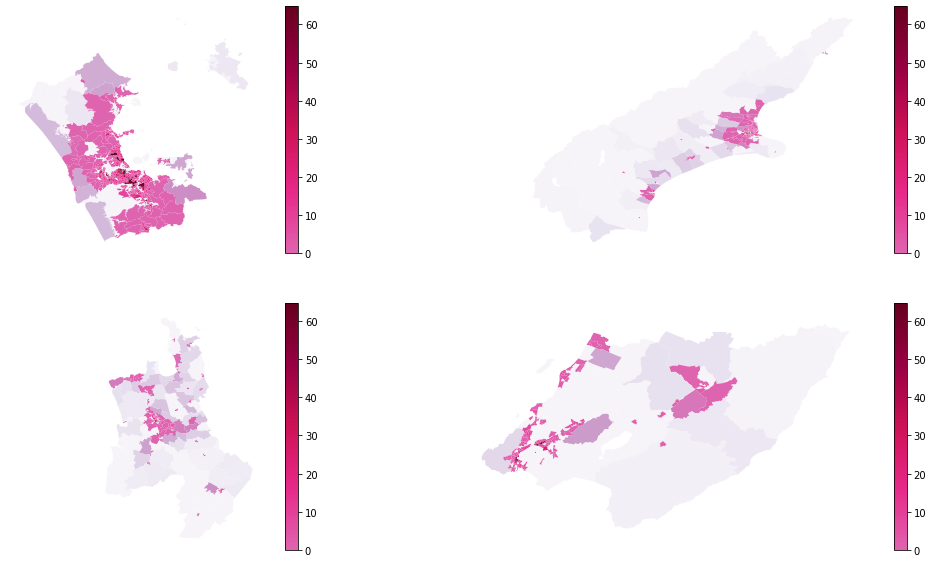

In [170]:

## F-density

#https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html

print(AKL.F_density.min(),AKL.F_density.max())
print(WKT.F_density.min(),WKT.F_density.max())
print(WLT.F_density.min(),WLT.F_density.max())
print(CAN.F_density.min(),CAN.F_density.max())


# normalize color
vmin, vmax, vcenter = 0, WKT.F_density.max(), WKT.F_density.median()
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# create a normalized colorbar
cmap = 'PuRd'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

#fig, ax = plt.subplots(2, 2, figsize=(15, 7))

fig, ax = plt.subplots(2, 2, figsize=(20,10))
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')

# Auckland
AKL.plot(column='F_density', cmap=cmap, norm=norm, legend=False, ax=ax[0,0])
CAN.plot(column='F_density', cmap=cmap, norm=norm, legend=False, ax=ax[0,1])
WKT.plot(column='F_density', cmap=cmap, norm=norm, legend=False, ax=ax[1,0])
WLT.plot(column='F_density', cmap=cmap, norm=norm, legend=False, ax=ax[1,1])
# add colorbar
fig.colorbar(cbar, ax=ax[0,0])
fig.colorbar(cbar, ax=ax[0,1])
fig.colorbar(cbar, ax=ax[1,0])
fig.colorbar(cbar, ax=ax[1,1])


0.0 1353.51572600305
0.0 160.372767070222
0.0 407.40613891067113
0.0 399.1481982514371


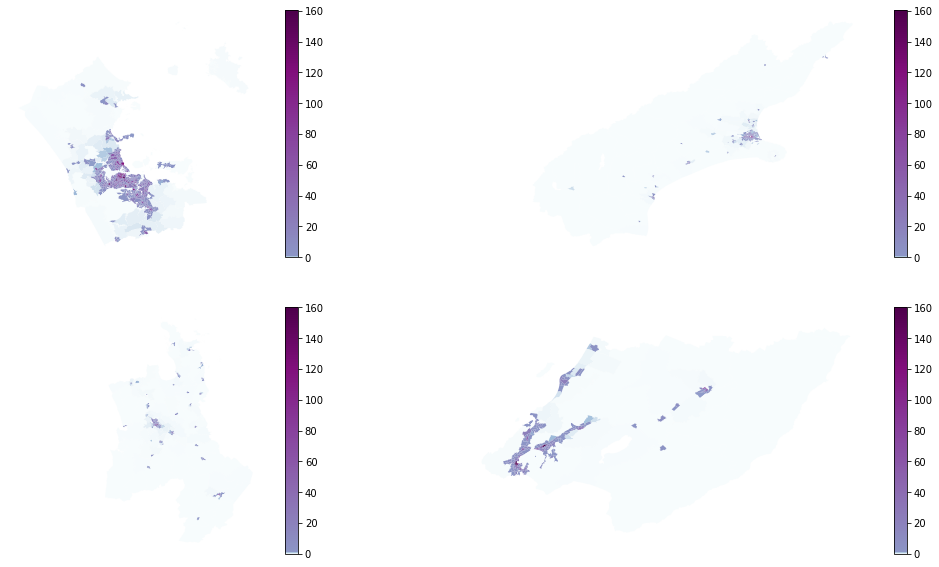

In [175]:
## G-density

#https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html

print(AKL.G_density.min(),AKL.G_density.max())
print(WKT.G_density.min(),WKT.G_density.max())
print(WLT.G_density.min(),WLT.G_density.max())
print(CAN.G_density.min(),CAN.G_density.max())


# normalize color
vmin, vmax, vcenter = 0, WKT.G_density.max(), WKT.G_density.median()
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# create a normalized colorbar
cmap = 'BuPu'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

#fig, ax = plt.subplots(2, 2, figsize=(15, 7))

fig, ax = plt.subplots(2, 2, figsize=(20,10))
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')

# Auckland
AKL.plot(column='G_density', cmap=cmap, norm=norm, legend=False, ax=ax[0,0])
CAN.plot(column='G_density', cmap=cmap, norm=norm, legend=False, ax=ax[0,1])
WKT.plot(column='G_density', cmap=cmap, norm=norm, legend=False, ax=ax[1,0])
WLT.plot(column='G_density', cmap=cmap, norm=norm, legend=False, ax=ax[1,1])
# add colorbar
fig.colorbar(cbar, ax=ax[0,0])
fig.colorbar(cbar, ax=ax[0,1])
fig.colorbar(cbar, ax=ax[1,0])
fig.colorbar(cbar, ax=ax[1,1])

0.0 47.378779459300404
0.0 11.776897471679291
0.0 11.204783793863239
0.0 13.077155201076993


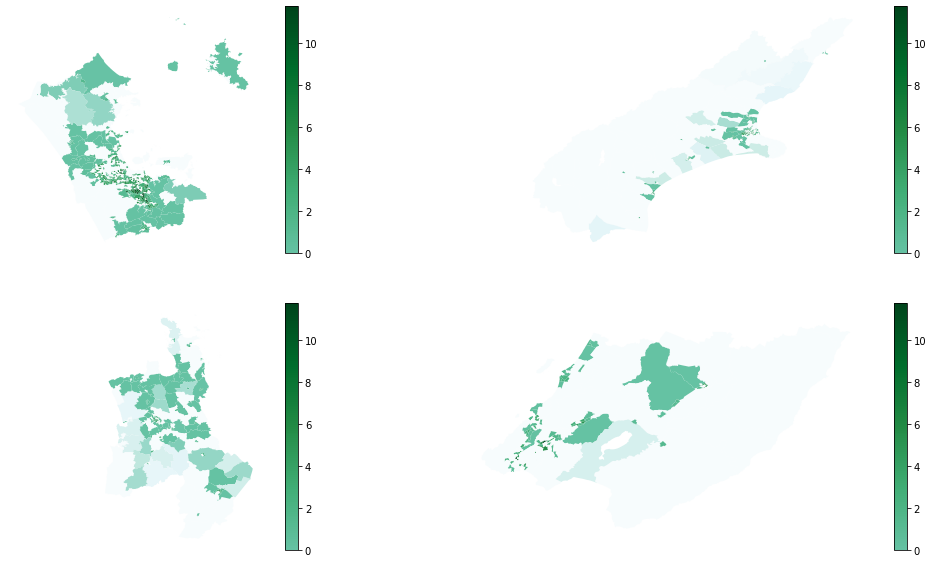

In [174]:
## Trans-density

#https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html

print(AKL.Trans_density.min(),AKL.Trans_density.max())
print(WKT.Trans_density.min(),WKT.Trans_density.max())
print(WLT.Trans_density.min(),WLT.Trans_density.max())
print(CAN.Trans_density.min(),CAN.Trans_density.max())


# normalize color
vmin, vmax, vcenter = 0, WKT.Trans_density.max(), WKT.Trans_density.median()
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# create a normalized colorbar
cmap = 'BuGn'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

#fig, ax = plt.subplots(2, 2, figsize=(15, 7))

fig, ax = plt.subplots(2, 2, figsize=(20,10))
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')

# Auckland
AKL.plot(column='Trans_density', cmap=cmap, norm=norm, legend=False, ax=ax[0,0])
CAN.plot(column='Trans_density', cmap=cmap, norm=norm, legend=False, ax=ax[0,1])
WKT.plot(column='Trans_density', cmap=cmap, norm=norm, legend=False, ax=ax[1,0])
WLT.plot(column='Trans_density', cmap=cmap, norm=norm, legend=False, ax=ax[1,1])
# add colorbar
fig.colorbar(cbar, ax=ax[0,0])
fig.colorbar(cbar, ax=ax[0,1])
fig.colorbar(cbar, ax=ax[1,0])
fig.colorbar(cbar, ax=ax[1,1])

0.0 70.61293582534189
0.0 8.716687114305149
0.0 9.700388230249406
0.0 28.83001872712694


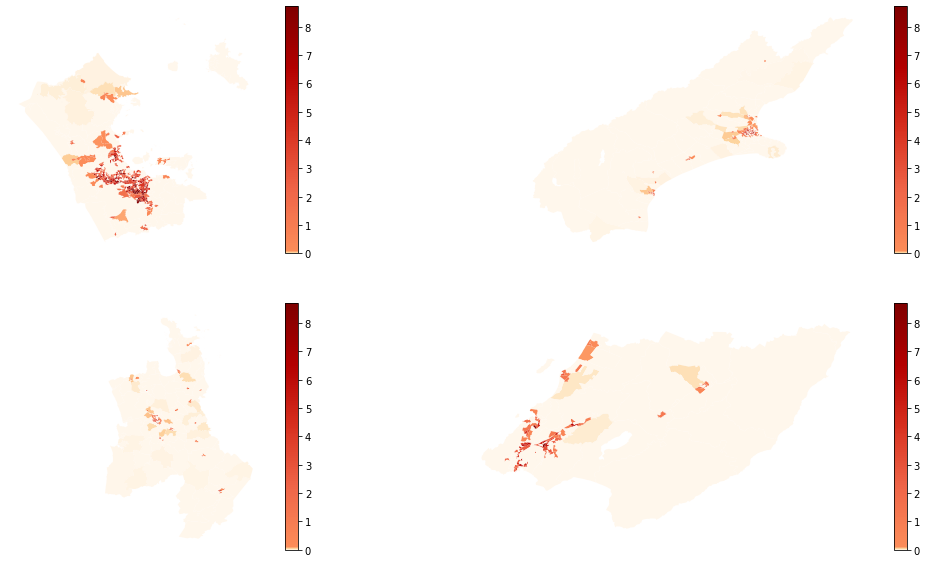

In [178]:
## Store-density

#https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html

print(AKL.Store_density.min(),AKL.Store_density.max())
print(WKT.Store_density.min(),WKT.Store_density.max())
print(WLT.Store_density.min(),WLT.Store_density.max())
print(CAN.Store_density.min(),CAN.Store_density.max())


# normalize color
vmin, vmax, vcenter = 0, WKT.Store_density.max(), 0.1
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# create a normalized colorbar
cmap = 'OrRd'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

#fig, ax = plt.subplots(2, 2, figsize=(15, 7))

fig, ax = plt.subplots(2, 2, figsize=(20,10))
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')

# Auckland
AKL.plot(column='Store_density', cmap=cmap, norm=norm, legend=False, ax=ax[0,0])
CAN.plot(column='Store_density', cmap=cmap, norm=norm, legend=False, ax=ax[0,1])
WKT.plot(column='Store_density', cmap=cmap, norm=norm, legend=False, ax=ax[1,0])
WLT.plot(column='Store_density', cmap=cmap, norm=norm, legend=False, ax=ax[1,1])
# add colorbar
fig.colorbar(cbar, ax=ax[0,0])
fig.colorbar(cbar, ax=ax[0,1])
fig.colorbar(cbar, ax=ax[1,0])
fig.colorbar(cbar, ax=ax[1,1])

0.0 19653.93380472016
0.0 1695.873235921818
0.0 7482.06014106895
0.0 2477.731268390997


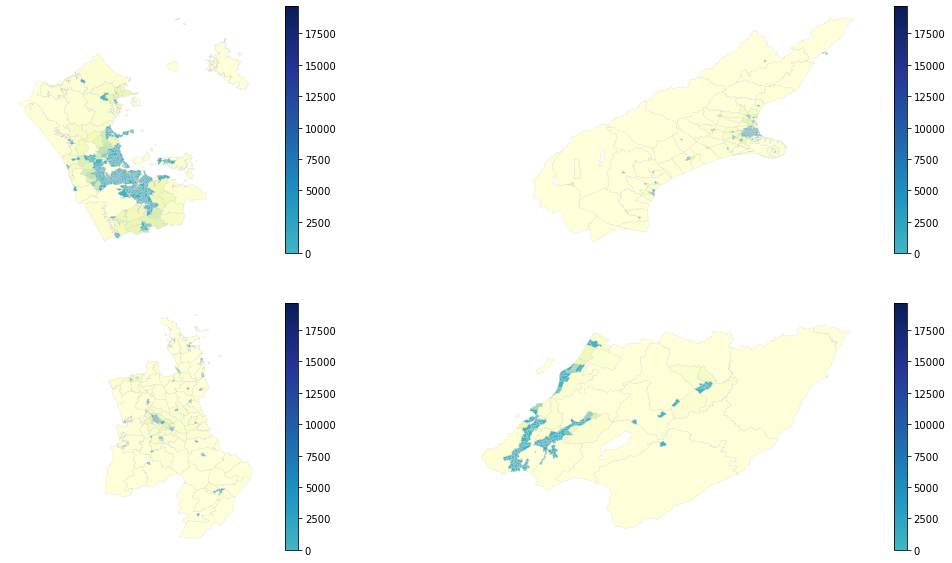

In [187]:
## All-density

#https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html

print(AKL.All_density.min(),AKL.All_density.max())
print(WKT.All_density.min(),WKT.All_density.max())
print(WLT.All_density.min(),WLT.All_density.max())
print(CAN.All_density.min(),CAN.All_density.max())


# normalize color
vmin, vmax, vcenter = 0, AKL.All_density.max(), WKT.All_density.median()
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# create a normalized colorbar
cmap = 'YlGnBu'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

#fig, ax = plt.subplots(2, 2, figsize=(15, 7))

fig, ax = plt.subplots(2, 2, figsize=(20,10))
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')

# Auckland
AKL.plot(column='All_density', cmap=cmap, norm=norm, legend=False, ax=ax[0,0],linewidth=0.2,edgecolor='0.8')
CAN.plot(column='All_density', cmap=cmap, norm=norm, legend=False, ax=ax[0,1],linewidth=0.2,edgecolor='0.8')
WKT.plot(column='All_density', cmap=cmap, norm=norm, legend=False, ax=ax[1,0],linewidth=0.2,edgecolor='0.8')
WLT.plot(column='All_density', cmap=cmap, norm=norm, legend=False, ax=ax[1,1],linewidth=0.2,edgecolor='0.8')
# add colorbar
fig.colorbar(cbar, ax=ax[0,0])
fig.colorbar(cbar, ax=ax[0,1])
fig.colorbar(cbar, ax=ax[1,0])
fig.colorbar(cbar, ax=ax[1,1])

In [190]:
np.percentile(AKL.All_density,0.75)

0.012391061146621089

In [177]:
print(WKT.Store_density.max())
print(WKT.Store_density.median())

8.716687114305149
0.0


<ipython-input-11-9f2a1bf6b62b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geometry'] = gpd.GeoSeries.from_wkt(df[fieldName])
/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


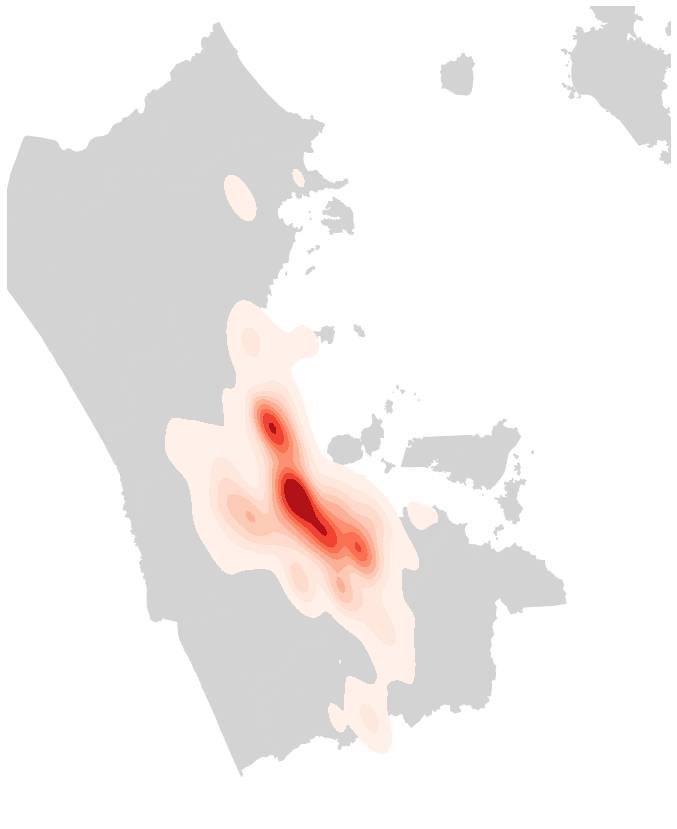

In [20]:
#KDE for an area only

#Filter df_multipoly
areaNames=subFileA['Area']
df_multipoly_area=df_multipoly.loc[df_multipoly['SA2_ascii'].isin(areaNames)]

f=kde_custom(df_multipoly_area,subFileA,df_centroid)

/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


<GeoAxesSubplot:>

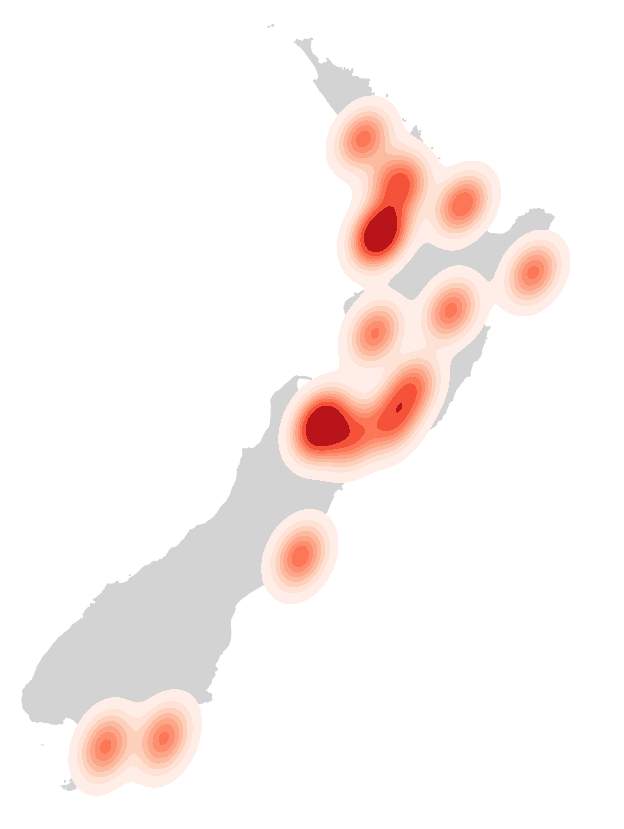

In [109]:
ax=gplt.polyplot(
    multipoly_gdf, 
    edgecolor="lightgray",
    facecolor="lightgray",
    figsize=(20, 15),
    projection=gcrs.WebMercator())

gplt.kdeplot(gdf_geogUnits, cmap="Reds", shade=True, ax=ax)

<GeoAxesSubplot:>

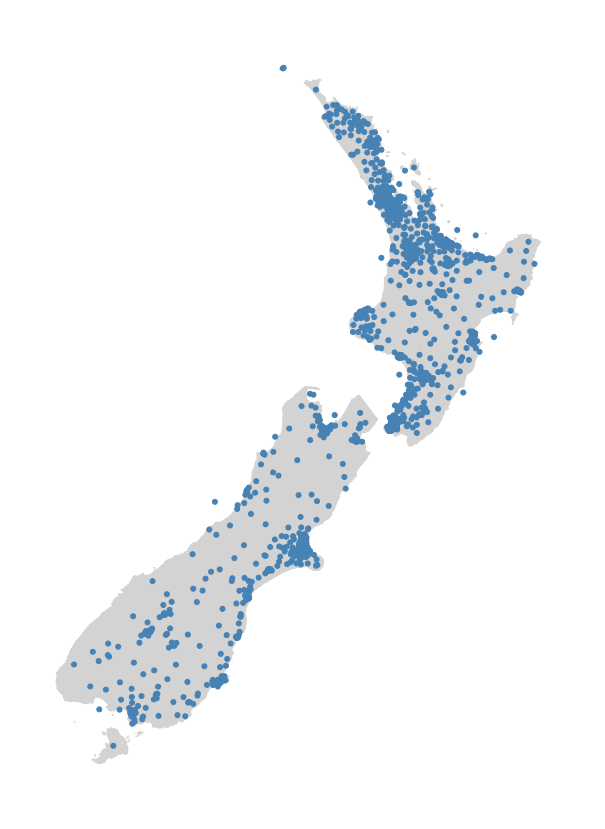

In [87]:
ax=gplt.polyplot(
    multipoly_gdf, 
    edgecolor="lightgray",
    facecolor="lightgray",
    figsize=(20, 15),
    projection=gcrs.WebMercator())

#gplt.kdeplot(gdf_geogUnits, cmap="Reds", shade=True, ax=ax)

gplt.pointplot(points_gdf,ax=ax)


In [104]:
subFileA.head()



,SA2_index,SA2_name,SA2_ascii,Land_area,Area,Length,geometry
0,100100,North Cape,North Cape,829.081715,829.081715,4.159623e+05,"MULTIPOLYGON (((172.64091 -34.46937, 172.64084..."
1,100200,Rangaunu Harbour,Rangaunu Harbour,273.936484,273.936484,1.491554e+05,"MULTIPOLYGON (((173.26863 -34.98589, 173.26858..."
2,100300,Inlets Far North District,Inlets Far North District,0.000000,626.101124,1.358870e+06,"MULTIPOLYGON (((173.73365 -35.00021, 173.73384..."
3,100400,Karikari Peninsula,Karikari Peninsula,174.188105,174.188105,1.400124e+05,"MULTIPOLYGON (((173.39523 -34.77785, 173.39522..."
4,100500,Tangonge,Tangonge,177.098445,177.098445,1.013318e+05,"MULTIPOLYGON (((173.17419 -35.15350, 173.16959..."


<GeoAxesSubplot:>

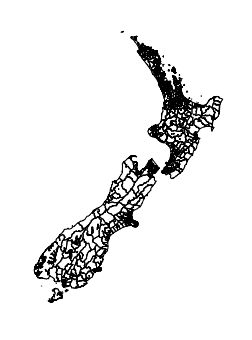

In [72]:
gplt.polyplot(multipoly_gdf,projection=gcrs.WebMercator())

In [ ]:
ax=gplt.polyplot(
    gdf, 
    edgecolor="lightgray",
    facecolor="lightgray",
    figsize=(20, 15),
    projection=gcrs.WebMercator())

gplt.kdeplot(gdf_geogUnits, cmap="Reds", shade=True, ax=ax)